##Prophet

In [ ]:
#!pip install prophet


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np
from tqdm import tqdm



In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/cleaned_data.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Load dish name mapping
mapping_df = pd.read_csv('/content/drive/MyDrive/desc_encoding_map.csv')
mapping_df = mapping_df.rename(columns={'Unnamed: 0': 'description', 'code': 'dish'})

In [ ]:
# Top 10 most sold dishes
top_dishes = df.groupby('clean_desc_encoded')['כמות'].sum().sort_values(ascending=False).head(10).index.tolist()

# Pivot for time series format
daily = df[df['clean_desc_encoded'].isin(top_dishes)].groupby(['Date', 'clean_desc_encoded'])['כמות'].sum().reset_index()
pivot_df = daily.pivot(index='Date', columns='clean_desc_encoded', values='כמות').fillna(0)

# Prophet loop
prophet_results = []

for dish in tqdm(top_dishes):
    df_prophet = pivot_df[[dish]].reset_index()
    df_prophet.columns = ['ds', 'y']
    df_prophet = df_prophet.dropna()
    df_prophet['y'] = df_prophet['y'].astype(float)

    split_idx = int(len(df_prophet) * 0.8)
    train = df_prophet.iloc[:split_idx]
    test = df_prophet.iloc[split_idx:]

    try:
        model = Prophet(weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=False)
        model.fit(train)

        future = model.make_future_dataframe(periods=len(test))
        forecast = model.predict(future)

        common_dates = test['ds'][test['ds'].isin(forecast['ds'])]
        pred = forecast.set_index('ds').loc[common_dates, 'yhat'].values
        test_y = test.set_index('ds').loc[common_dates, 'y'].values

        # Metrics
        mae = mean_absolute_error(test_y, pred)
        rmse = np.sqrt(mean_squared_error(test_y, pred))
        r2 = r2_score(test_y, pred)
        n = len(test_y)
        p = 0  # Prophet doesn’t use explicit regressors here
        adj_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))

        mask = test_y > 0
        mape = np.mean(np.abs((test_y[mask] - pred[mask]) / test_y[mask])) * 100 if mask.sum() > 0 else np.nan

        prophet_results.append({
            'dish': dish,
            'MAE': np.ceil(mae),
            'RMSE': np.ceil(rmse),
            'MAPE (%)': np.ceil(mape),
            'R2': r2,
            'Adjusted R2': adj_r2
        })

    except Exception as e:
        print(f"❌ Error en dish {dish}: {e}")
        prophet_results.append({
            'dish': dish,
            'MAE': np.nan,
            'RMSE': np.nan,
            'MAPE (%)': np.nan,
            'R2': np.nan,
            'Adjusted R2': np.nan
        })

# Final table with dish names
results_df = pd.DataFrame(prophet_results)
results_df = results_df.merge(mapping_df, on='dish', how='left')
results_df = results_df[['dish', 'description', 'MAE', 'RMSE', 'MAPE (%)', 'R2', 'Adjusted R2']].sort_values('RMSE').reset_index(drop=True)
results_df


  0%|          | 0/10 [00:00<?, ?it/s]DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm_it4so/bleth1pn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm_it4so/hpunxlt5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47852', 'data', 'file=/tmp/tmpdm_it4so/bleth1pn.json', 'init=/tmp/tmpdm_it4so/hpunxlt5.json', 'output', 'file=/tmp/tmpdm_it4so/prophet_model8fb9bxcl/prophet_model-20250417090356.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:03:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:03:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
 10%|█         | 1/10 [00:00<00:04,  2.07it/s]DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm_it4so/8pu1j5lj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm_it4so/jxiqdj0g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmds

,dish,description,MAE,RMSE,MAPE (%),R2,Adjusted R2
0,65,קלאסית 16,5.0,6.0,64.0,0.019477,0.019477
1,64,קלאסית דקה 14,5.0,7.0,62.0,0.068671,0.068671
2,53,פיצה אישית,6.0,8.0,83.0,-0.616704,-0.616704
3,43,בצל סגול,9.0,11.0,96.0,-0.303583,-0.303583
4,34,פטריות,11.0,14.0,81.0,-0.108381,-0.108381
5,63,קלאסית 8,14.0,16.0,117.0,-3.330232,-3.330232
6,35,תירס,14.0,18.0,128.0,-3.130261,-3.130261
7,36,זיתים ירוקים,16.0,20.0,90.0,-0.579387,-0.579387
8,62,קלאסית 14,20.0,26.0,53.0,0.028774,0.028774
9,224,פיצה מיוחדת ממהדורת חורף פיצה קלאסית,66.0,81.0,313.0,-8.784594,-8.784594


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm_it4so/iann4i7r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm_it4so/b652jd4i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48731', 'data', 'file=/tmp/tmpdm_it4so/iann4i7r.json', 'init=/tmp/tmpdm_it4so/b652jd4i.json', 'output', 'file=/tmp/tmpdm_it4so/prophet_modelkkd9y2lk/prophet_model-20250417090523.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:05:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:05:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


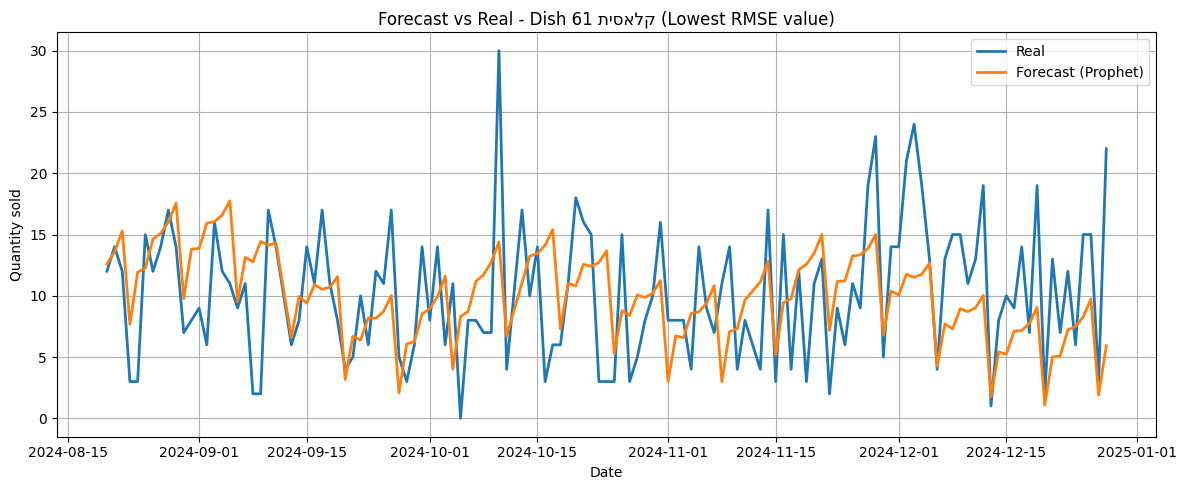

In [ ]:
# 🔍 Plato con menor RMSE
best_dish = results_df.iloc[0]['dish']
best_dish_name = results_df.iloc[0]['description'][::-1]  # invertimos el texto hebreo para mostrarlo bien

# 📦 Preparar datos para el mejor plato
df_prophet = pivot_df[[best_dish]].reset_index()
df_prophet.columns = ['ds', 'y']
df_prophet = df_prophet.dropna()
df_prophet['y'] = df_prophet['y'].astype(float)

# 🧪 Train/Test split
split_idx = int(len(df_prophet) * 0.8)
train = df_prophet.iloc[:split_idx]
test = df_prophet.iloc[split_idx:]

# 🔮 Entrenar y predecir
model = Prophet(weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=False)
model.fit(train)
future = model.make_future_dataframe(periods=len(test))
forecast = model.predict(future)

# 📊 Forecast vs Real
common_dates = test['ds'][test['ds'].isin(forecast['ds'])]
pred = forecast.set_index('ds').loc[common_dates, 'yhat']
real = test.set_index('ds').loc[common_dates, 'y']

# 📈 Plot
plt.figure(figsize=(12, 5))
plt.plot(real.index, real, label='Real', linewidth=2)
plt.plot(pred.index, pred, label='Forecast (Prophet)', linewidth=2)
plt.title(f'Forecast vs Real - Dish {best_dish_name} (Lowest RMSE value)')
plt.xlabel('Date')
plt.ylabel('Quantity sold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Prepare data for a specific dish (example: dish 64)
df_prophet = pivot_df[[64]].reset_index()
df_prophet.columns = ['ds', 'y']  # Prophet requires 'ds' for dates and 'y' for values
df_prophet = df_prophet.dropna()

# Fit the Prophet model using ALL available data
model = Prophet(weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=False)
model.fit(df_prophet)

# Extend the timeline to include future dates
future = model.make_future_dataframe(periods=250)  # adjust the period as needed
forecast = model.predict(future)

# Pick a future date to forecast
target_date = '2025-05-20'

# Retrieve and round the forecasted value
pred_value = forecast.loc[forecast['ds'] == target_date, 'yhat']

if not pred_value.empty:
    rounded_value = int(np.ceil(pred_value.values[0]))
    print(f"📆 Forecast for {target_date}: {rounded_value} units sold")
else:
    print(f"⚠️ No prediction found for the date {target_date}")


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm_it4so/fmrt13xb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm_it4so/z_n1g90s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35401', 'data', 'file=/tmp/tmpdm_it4so/fmrt13xb.json', 'init=/tmp/tmpdm_it4so/z_n1g90s.json', 'output', 'file=/tmp/tmpdm_it4so/prophet_modelv4pm5loi/prophet_model-20250417090614.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:06:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:06:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


📆 Forecast for 2025-05-20: 12 units sold
